In [1]:
import numpy as np
import pandas as pd
import open3d as o3d
import pymeshlab as pyml
import time 
import os
import trimesh


import matplotlib.pyplot as plt
import seaborn as sns


import pclpy
from pclpy import pcl
from plyfile import PlyData, PlyElement

In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.max_colwidth", 256)

In [3]:
%matplotlib inline
sns.set(rc={'figure.figsize':(8,6)})


In [4]:
INPUT_PATH = os.getcwd()+'\\Save data\\Processed_data'
OUTPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'

INPUT_TEMP_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output_temp'
OUTPUT_PATH = os.getcwd()+'\\Save data\\Processed_data\\Output'


In [5]:
patient_id_list = '2_BC	3_BC	4_BC	5_BM	6_BM	7_BP	8_BP	9_KBW	10_SUM	11_DHM	12_GAW	13_PMM	14_TR	15_TR	16_TR	18_EM	19_EM	20_EM	21_FA	22_FA	23_HJ	24_HJ	25_HM	26_HM	27_HM	28_JM	29_JM	30_JM	31_JM	32_JM	33_KBB	34_KBB	35_KBB	36_KBB	37_KBB	38_KBB	39_KBB	40_KBB	41_KBB	42_KBB	43_KBB	44_AC	45_AC	46_LE	47_LE	48_LE	49_LE	50_LE	51_LE	52_LE	53_LS	54_MR	55_MR	56_WA	57_SF	58_SI	59_SI'
patient_id_list = patient_id_list.split()
patient_id_list[:5]

['2_BC', '3_BC', '4_BC', '5_BM', '6_BM']

In [199]:
ORIGINAL_FILENAME = "_PLY0.ply"
WSS_FILENAME = "_WSS.csv"
WSS_DOWN_FILENME = "_WSS_down.csv"

# PATIENT_ID = "bm"

PYMESH_FILENAME = "pymesh.ply"
DESC_1_FILENAME = "fpfh.ply"
DESC_2_FILENAME = "usc.ply"

RADIUS = 0.0002
RADIUS_SEARCH = 0.0005

os.path.join(OUTPUT_TEMP_PATH,f"{ORIGINAL_FILENAME}_{PYMESH_FILENAME}")

'D:\\Workspace\\Python\\Thesis Data\\Save data\\Processed_data\\Output_temp\\_PLY0.ply_pymesh.ply'

In [7]:
print (f"TOTAL FILES TO BE PROCESSED: {len(patient_id_list)}")

TOTAL FILES TO BE PROCESSED: 57


## 1. Cleaning and Downsampling
##### Using Meshlab

In [198]:
counter = 1
for PATIENT_ID in patient_id_list:
    print(f"\nProcessing File at:")
    print(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    
    ms = pyml.MeshSet()

    TARGET_FACE_COUNT = 30000


    ms.load_new_mesh(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    ms.apply_filter('repair_non_manifold_edges_by_removing_faces')
    ms.apply_filter('simplification_quadric_edge_collapse_decimation',targetfacenum  = TARGET_FACE_COUNT, preserveboundary= True,
                   preservenormal = True, preservetopology = True)

    # ms.save_current_mesh(os.path.join(path,"bm_pymesh.ply"),format = 'ascii' )
    ms.save_current_mesh(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_binary_{PYMESH_FILENAME}") )
    
    
    
    #Convert BINARY to ASCII
    plydata = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_binary_{PYMESH_FILENAME}"), mmap=False)
    pl_wr = PlyData(plydata.elements, text = True, comments = ['PLYFILE BINARY TO ASCII CONVERTED'])
    pl_wr.write(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))
    
    os.remove(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_binary_{PYMESH_FILENAME}"))
    
    print(f"Finished processing {counter} files ")
    counter = counter + 1


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\2_BC_PLY0.ply
Finished processing 1 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\3_BC_PLY0.ply
Finished processing 2 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\4_BC_PLY0.ply
Finished processing 3 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\5_BM_PLY0.ply
Finished processing 4 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\6_BM_PLY0.ply
Finished processing 5 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\7_BP_PLY0.ply
Finished processing 6 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\8_BP_PLY0.ply
Finished processing 7 files 

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\9_KBW_PLY0.ply
Finished processing 8 files 

Processing File at:
D:\Workspa

In [8]:
radius_columns = ['original_points','sampled_points','radius_mean','radius_median','radius_std','radius_min','radius_max',]
radius_df = pd.DataFrame(index=patient_id_list, columns = radius_columns )
radius_df.head(2)

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Compute Curvature Features

### 2.1 Check Radius for different dataset files

In [210]:
for PATIENT_ID in patient_id_list:

    #LOAD Point Cloud in o3d instance
    pc_original = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))

    #Compute nearest distance
    NN_dist = pc_o3d.compute_nearest_neighbor_distance()
    
    radius_df.loc[PATIENT_ID] = [len(np.asarray(pc_original.points)),len(np.asarray(pc_o3d.points)), 
                          np.mean(NN_dist), np.median(NN_dist), np.std(NN_dist), np.min(NN_dist), np.max(NN_dist)
                         ]

# df = df.astype(float)
radius_df = radius_df.infer_objects()
# pd.to_numeric(df, downcast='float')
radius_df.head(5)

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,77127,15307,0.000114,0.000114,0.000026,0.000011,0.000245
3_BC,28274,15271,0.000119,0.000117,0.000026,0.000014,0.000244
4_BC,22604,15223,0.000110,0.000103,0.000019,0.000030,0.000222
5_BM,95358,15366,0.000176,0.000173,0.000057,0.000033,0.000480
6_BM,20744,15154,0.000087,0.000084,0.000017,0.000033,0.000179


In [211]:
radius_df

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
2_BC,77127,15307,0.000114,0.000114,0.000026,0.000011,0.000245
3_BC,28274,15271,0.000119,0.000117,0.000026,0.000014,0.000244
4_BC,22604,15223,0.000110,0.000103,0.000019,0.000030,0.000222
5_BM,95358,15366,0.000176,0.000173,0.000057,0.000033,0.000480
6_BM,20744,15154,0.000087,0.000084,0.000017,0.000033,0.000179
7_BP,68120,15286,0.000077,0.000075,0.000021,0.000022,0.000193
8_BP,88042,15376,0.000088,0.000087,0.000023,0.000020,0.000207
9_KBW,79622,15393,0.000103,0.000102,0.000029,0.000022,0.000244
10_SUM,70856,15155,0.000099,0.000097,0.000026,0.000035,0.000272
11_DHM,76754,15304,0.000102,0.000101,0.000028,0.000035,0.000225


In [212]:
radius_df.describe(percentiles = np.arange(0,1.1,0.1))

,original_points,sampled_points,radius_mean,radius_median,radius_std,radius_min,radius_max
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,69993.087719,15298.456140,0.000098,0.000096,0.000026,0.000022,0.000235
std,19124.562555,84.554942,0.000019,0.000018,0.000006,0.000010,0.000050
min,20744.000000,15149.000000,0.000063,0.000061,0.000017,0.000002,0.000148
0%,20744.000000,15149.000000,0.000063,0.000061,0.000017,0.000002,0.000148
10%,40221.400000,15174.600000,0.000077,0.000076,0.000020,0.000009,0.000183
20%,59505.800000,15225.200000,0.000083,0.000082,0.000022,0.000013,0.000194
30%,64185.400000,15265.800000,0.000087,0.000086,0.000023,0.000016,0.000208
40%,71000.800000,15275.800000,0.000092,0.000091,0.000024,0.000018,0.000223
50%,74286.000000,15300.000000,0.000099,0.000097,0.000026,0.000022,0.000235


In [213]:
radius_df.describe().radius_max["50%"]

0.0002354071108829738

In [214]:
radius_df.iloc[[np.argmax(radius_df.radius_max)]].index.values[0]

'5_BM'

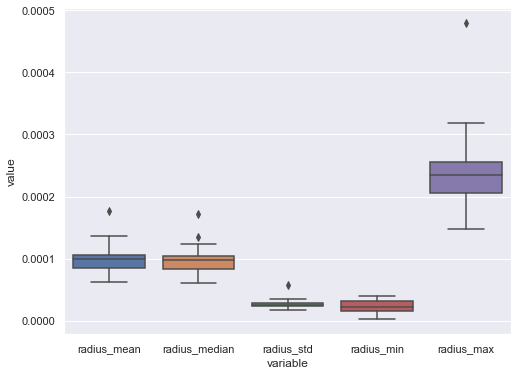

In [215]:
sns.boxplot(x="variable", y="value", data=pd.melt(radius_df.iloc[:,2:]))

plt.show()

### 2.2 Adjust RADIUS SEARCH - Using nearest distance between points

### Lowest Max distance dataset 

In [86]:
# Get the Patient ID for the lowest max dist
P_ID = radius_df.iloc[[np.argmin(radius_df.radius_max)]].index.values[0]
print(f"Dataset PATIENT ID = {P_ID}")

Dataset PATIENT ID = 27_HM


In [87]:
#LOAD Point Cloud in o3d instance
pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_{PYMESH_FILENAME}"))

#Compute nearest distance
NN_dist = pc_o3d.compute_nearest_neighbor_distance()
pd.Series(NN_dist).describe()

count    17714.000000
mean         0.000067
std          0.000015
min          0.000013
25%          0.000056
50%          0.000066
75%          0.000077
max          0.000145
dtype: float64

In [88]:
np.argmin(np.array(NN_dist)), np.argmax(np.array(NN_dist))

(5432, 7081)

In [89]:
np.array(NN_dist)[np.argmin(np.array(NN_dist))], np.array(NN_dist)[np.argmax(np.array(NN_dist))]

(1.3284720147148752e-05, 0.00014474396747135994)

In [90]:
#Build tree
RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)
o3d_kdtree = o3d.geometry.KDTreeFlann(pc_o3d)
print(f"Current Search Radius = {RADIUS_SEARCH}")

# Radius search 
search_pt_min = pc_o3d.points[np.argmin(np.array(NN_dist))]
search_pt_max = pc_o3d.points[np.argmax(np.array(NN_dist))]

# search_pt = [ 0.02097408,  0.0077485 , -0.0230285 ]
[k_min, idx_min, _] = o3d_kdtree.search_radius_vector_3d(search_pt_min, RADIUS_SEARCH)
[k_max, idx_max, _] = o3d_kdtree.search_radius_vector_3d(search_pt_max, RADIUS_SEARCH)

print(f"\nTotal neighbourhood points for the point with: \nmin dist = {k_min} \nmax dist = {k_max}")

Current Search Radius = 0.00022

Total neighbourhood points for the point with: 
min dist = 27 
max dist = 10


### Highest Max distance dataset 

In [70]:
# Get the Patient ID for the lowest max dist
P_ID = radius_df.iloc[[np.argmax(radius_df.radius_max)]].index.values[0]
print(f"Dataset PATIENT ID = {P_ID}")

Dataset PATIENT ID = 5_BM


In [71]:
#LOAD Point Cloud in o3d instance
pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_{PYMESH_FILENAME}"))

#Compute nearest distance
NN_dist = pc_o3d.compute_nearest_neighbor_distance()
pd.Series(NN_dist).describe()

count    17866.000000
mean         0.000164
std          0.000052
min          0.000033
25%          0.000129
50%          0.000159
75%          0.000196
max          0.000443
dtype: float64

In [72]:
np.argmin(np.array(NN_dist)), np.argmax(np.array(NN_dist))

(38, 10483)

In [73]:
np.array(NN_dist)[np.argmin(np.array(NN_dist))], np.array(NN_dist)[np.argmax(np.array(NN_dist))]

(3.331233136310011e-05, 0.00044287037732767707)

In [79]:
#Build tree
RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)
o3d_kdtree = o3d.geometry.KDTreeFlann(pc_o3d)
print(f"Current Search Radius = {RADIUS_SEARCH}")

# Radius search 
search_pt_min = pc_o3d.points[np.argmin(np.array(NN_dist))]
search_pt_max = pc_o3d.points[np.argmax(np.array(NN_dist))]

# search_pt = [ 0.02097408,  0.0077485 , -0.0230285 ]
[k_min, idx_min, _] = o3d_kdtree.search_radius_vector_3d(search_pt_min, RADIUS_SEARCH)
[k_max, idx_max, _] = o3d_kdtree.search_radius_vector_3d(search_pt_max, RADIUS_SEARCH)

print(f"\nTotal neighbourhood points for the point with: \nmin dist = {k_min} \nmax dist = {k_max}")

Current Search Radius = 0.00022

Total neighbourhood points for the point with: 
min dist = 18 
max dist = 1


### 2.2 Compute Gaussian & Mean curvature using Radius

### Lowest Max distance dataset 

In [118]:
# Get the Patient ID for the lowest max dist
P_ID = radius_df.iloc[[np.argmin(radius_df.radius_max)]].index.values[0]
print(f"Dataset PATIENT ID = {P_ID}")

Dataset PATIENT ID = 27_HM


In [119]:
#Load Mesh in Trimesh object
tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_{PYMESH_FILENAME}"))

In [120]:
# tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))

gaus_curv = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*0.8)


In [121]:
pd.Series(gaus_curv*1000).describe()

count    17714.000000
mean         0.052714
std          0.040320
min         -0.195450
25%          0.033855
50%          0.049860
75%          0.072173
max          0.242533
dtype: float64

In [122]:
np.std(gaus_curv)/np.mean(gaus_curv)

0.7648576821972698

In [123]:
np.std(gaus_curv)/(np.max(gaus_curv)-np.min(gaus_curv)) 

0.09205484444088412

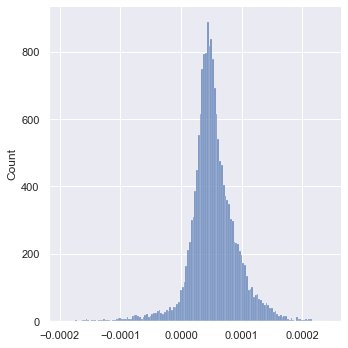

In [124]:
sns.displot(pd.Series(gaus_curv))

### Highest Max distance dataset 

In [125]:
# Get the Patient ID for the lowest max dist
P_ID = radius_df.iloc[[np.argmax(radius_df.radius_max)]].index.values[0]
print(f"Dataset PATIENT ID = {P_ID}")

Dataset PATIENT ID = 5_BM


In [126]:
#Load Mesh in Trimesh object
tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_{PYMESH_FILENAME}"))

In [127]:
# tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))

gaus_curv = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH)


In [128]:
pd.Series(gaus_curv*1000).describe()

count    17866.000000
mean         0.039168
std          0.065450
min         -0.513022
25%          0.013424
50%          0.038287
75%          0.068857
max          0.508381
dtype: float64

In [129]:
np.std(gaus_curv)/np.mean(gaus_curv)

1.6709373772493192

In [130]:
np.std(gaus_curv)/(np.max(gaus_curv)-np.min(gaus_curv)) 

0.0640763316697895

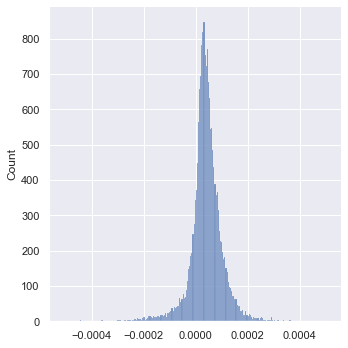

In [131]:
sns.displot(pd.Series(gaus_curv))

### Different Radius changes for a dataset

In [160]:
#Load Mesh in Trimesh object
tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{'49_LE'}_{PYMESH_FILENAME}"))

In [161]:
tr_mesh.vertices

TrackedArray([[-0.06159872, -0.14171845, -0.17648934],
              [-0.05765888, -0.14234741, -0.18073061],
              [-0.06289664, -0.14549246, -0.17577928],
              ...,
              [-0.05833473, -0.14151946, -0.17470159],
              [-0.06094849, -0.14529485, -0.17788243],
              [-0.05898241, -0.14158936, -0.17543007]])

In [162]:
#Create a df with x,y,z points for storing curvature values

curv_df = pd.DataFrame(data =tr_mesh.vertices , columns = ["Points:0", "Points:1", "Points:2"])
curv_df.head(2)

,Points:0,Points:1,Points:2
0,-0.061599,-0.141718,-0.176489
1,-0.057659,-0.142347,-0.180731


##### Compute curvature using RADIUS_SEARCH as radius

#### Normalize Std by dividing with mean - CV
https://math.stackexchange.com/questions/260617/how-to-determine-if-standard-deviation-is-high-low

#### 

In [163]:
# tr_mesh = trimesh.load(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))

gaus_curv = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH)


In [164]:
gaus_curv2 = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*0.5)


In [165]:
gaus_curv3 = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*1.2)


In [166]:
gaus_curv4 = trimesh.curvature.discrete_mean_curvature_measure(mesh = tr_mesh, points = tr_mesh.vertices, 
                                                              radius =  RADIUS_SEARCH*1.5)


In [167]:
pd.Series(gaus_curv*1000).describe()

count    17812.000000
mean         0.149375
std          0.127177
min         -0.468171
25%          0.097161
50%          0.140525
75%          0.201157
max          0.620297
dtype: float64

In [168]:
 np.std(gaus_curv)/np.mean(gaus_curv),  np.std(gaus_curv2)/np.mean(gaus_curv2),  np.std(gaus_curv3)/np.mean(gaus_curv3),  np.std(gaus_curv4)/np.mean(gaus_curv4)


(0.8513723624441555,
 1.0778733663985731,
 0.8096280876557426,
 0.7626092370196917)

In [169]:
np.std(gaus_curv)/(np.max(gaus_curv)-np.min(gaus_curv)) 

0.11683733055281371

In [170]:
np.std(gaus_curv2)/(np.max(gaus_curv2)-np.min(gaus_curv2)), np.std(gaus_curv3)/(np.max(gaus_curv3) - np.min(gaus_curv3)) 

(0.08841426098142535, 0.12893699524734636)

In [171]:
np.std(gaus_curv4)/(np.max(gaus_curv4)-np.min(gaus_curv4)),

(0.13976074158373453,)

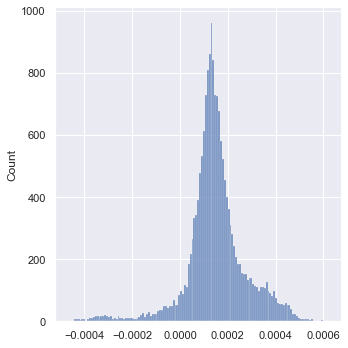

In [172]:
sns.displot(pd.Series(gaus_curv))

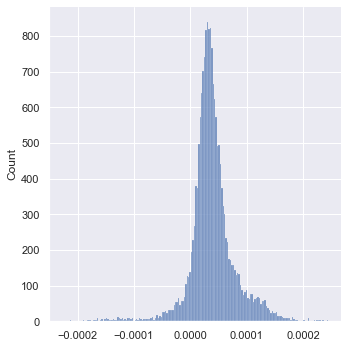

In [173]:
sns.displot(pd.Series(gaus_curv2))

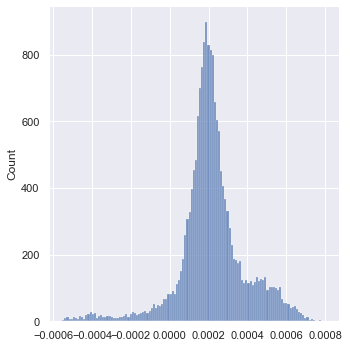

In [174]:
sns.displot(pd.Series(gaus_curv3))

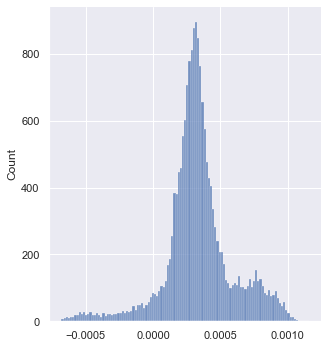

In [175]:
sns.displot(pd.Series(gaus_curv4))

## 3. WSS

In [133]:
wss_columns = ['original_points','sampled_points','wss_mean','wss_median','wss_std','wss_min','wss_max',]
wss_eda = pd.DataFrame(index=patient_id_list, columns = wss_columns )
wss_eda.head(2)

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3_BC,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
for PATIENT_ID in patient_id_list:
    print(f"\nProcessing File at:")
    print(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    
    df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
    
    wss_eda.loc[PATIENT_ID] = [df_wss.shape[0],np.nan, 
                          np.mean(df_wss.WSS), np.median(df_wss.WSS), np.std(df_wss.WSS), np.min(df_wss.WSS), np.max(df_wss.WSS)
                         ]
wss_eda = wss_eda.infer_objects()
wss_eda.head()


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\2_BC_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\3_BC_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\4_BC_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\5_BM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\6_BM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\7_BP_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\8_BP_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\9_KBW_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\10_SUM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\11_DHM_PLY0.ply

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_da

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,77127,NaN,2.664416,1.991029,2.601829,0.000063,21.984079
3_BC,28274,NaN,7.343544,7.063340,4.074379,0.073806,31.608334
4_BC,22604,NaN,7.312326,7.512783,2.861085,0.083918,24.377111
5_BM,95358,NaN,9.055627,5.069889,9.886064,0.005298,91.338405
6_BM,20744,NaN,6.449848,4.178266,6.059387,0.007637,36.123463


In [135]:
wss_eda

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
2_BC,77127,NaN,2.664416,1.991029,2.601829,0.000063,21.984079
3_BC,28274,NaN,7.343544,7.063340,4.074379,0.073806,31.608334
4_BC,22604,NaN,7.312326,7.512783,2.861085,0.083918,24.377111
5_BM,95358,NaN,9.055627,5.069889,9.886064,0.005298,91.338405
6_BM,20744,NaN,6.449848,4.178266,6.059387,0.007637,36.123463
7_BP,68120,NaN,24.352395,22.118984,20.105235,0.010296,153.113420
8_BP,88042,NaN,19.285902,16.796509,15.474012,0.031380,165.442650
9_KBW,79622,NaN,4.818911,4.252105,2.842062,0.031608,19.851186
10_SUM,70856,NaN,6.501759,5.127805,5.408897,0.007576,39.244955
11_DHM,76754,NaN,4.651126,3.326295,4.251434,0.008460,52.571410


In [144]:
wss_eda.describe(percentiles = np.linspace(0.5,1.0,10))

,original_points,sampled_points,wss_mean,wss_median,wss_std,wss_min,wss_max
count,57.000000,0.0,57.000000,57.000000,57.000000,57.000000,57.000000
mean,69993.087719,NaN,15.404597,13.254380,12.644712,0.035336,141.305587
std,19124.562555,NaN,16.532721,15.237611,15.194525,0.041364,275.651552
min,20744.000000,NaN,2.664416,0.544347,1.971920,0.000002,17.415271
50%,74286.000000,NaN,10.643519,9.425014,8.670265,0.019444,79.396483
55.6%,75440.888889,NaN,11.936668,9.858273,9.642366,0.025249,91.680991
61.1%,76219.666667,NaN,13.936746,12.527588,10.984439,0.030018,105.763376
66.7%,77024.333333,NaN,15.668227,12.991728,12.100439,0.031673,125.411953
72.2%,78797.555556,NaN,16.840249,13.637538,13.535132,0.041173,136.615740
77.8%,81400.444444,NaN,19.691919,16.006292,15.503034,0.052133,152.431620


In [139]:
wss_eda.query("wss_max >= 400").index.values

array(['49_LE', '53_LS'], dtype=object)

In [148]:
wss_eda.query("wss_std >= 40").index.values

array(['49_LE', '53_LS'], dtype=object)

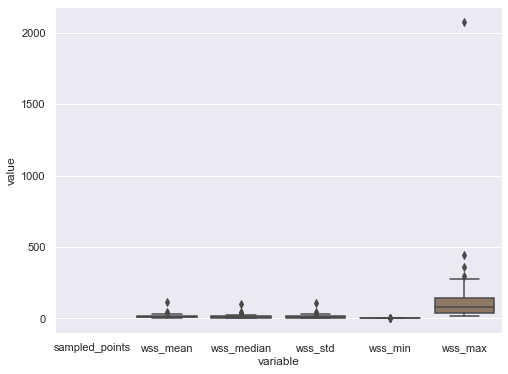

In [123]:
sns.boxplot(x="variable", y="value", data=pd.melt(wss_eda.iloc[:,1:]))

plt.show()

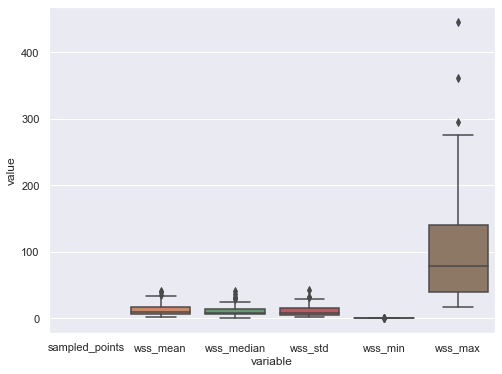

In [128]:
sns.boxplot(x="variable", y="value", data=pd.melt(wss_eda.query("wss_max <= 500").iloc[:,1:]))

plt.show()

In [132]:
df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{'49_LE'}{WSS_FILENAME}"))
df_wss.shape

(87193, 4)

In [134]:
df_wss.query(" WSS > 150").shape

(26924, 4)

In [135]:
(df_wss.query(" WSS > 150").shape[0]/df_wss.shape[0])*100

30.87862557774133

### Calculate WSS for downsampled point cloud

In [207]:
def get_total_runtime(start, end):
    temp = end-start
    print("Total seconds = %d" %temp)
    hours = temp//3600
    temp = temp - 3600*hours
    minutes = temp//60
    seconds = temp - 60*minutes
    print('Current file finished in %d hrs %d mins %d secs' %(hours,minutes,seconds))

In [149]:
# Get the Patient ID for the lowest max dist
P_ID = radius_df.iloc[[np.argmax(radius_df.radius_max)]].index.values[0]
print(f"Dataset PATIENT ID = {P_ID}")

Dataset PATIENT ID = 5_BM


In [157]:
#Read original file with WSS
df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{P_ID}{WSS_FILENAME}"))
df_wss.head(10)

,Points:0,Points:1,Points:2,WSS
0,0.013236,-0.001791,-0.030957,27.287485
1,0.013193,-0.001798,-0.031024,27.067192
2,0.013188,-0.001711,-0.031044,25.569170
3,0.013232,-0.001703,-0.030977,25.804458
4,0.017855,-0.005076,-0.031529,11.852991
5,0.017903,-0.005037,-0.031465,11.931856
6,0.017882,-0.005099,-0.031415,11.248607
7,0.017834,-0.005137,-0.031478,11.170350
8,0.016643,-0.006196,-0.030867,8.897130
9,0.016709,-0.006162,-0.030909,8.588890


#### REMOVE PATIENT_IDS WHICH ARE OUTLIERS


In [222]:
#REMOVE PATIENT_IDS WHICH ARE OUTLIERS
patient_id_list_new = [x for x in patient_id_list if x not in wss_eda.query("wss_std >= 40").index.values]

In [231]:
for PATIENT_ID in patient_id_list_new[17:30]:
    print(f"\nProcessing File at:")
    print(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    
    start = time.time()

    #Read original file with WSS
    df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
    #Round the points
    df_wss = np.around(df_wss,8).copy()
    
    #Create a df to save the files
    columns_wss_downsampled = ['x','y','z','WSS']
    df_wss_downsampled = pd.DataFrame(columns = columns_wss_downsampled )

    #Read Original and Downsampled point cloud
    pc_org = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    pc_down = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))

    #Build tree for original point cloud
    kdtree_org = o3d.geometry.KDTreeFlann(pc_org)

    # Radius search 
    RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)
#     RADIUS_SEARCH = 0.00022

    for i in range(np.array(pc_down.points).shape[0]):
#     for i in range(10):

        search_pt = np.around(np.array(pc_down.points)[i], decimals = 8) 
        [k_org, idx_org, _] = kdtree_org.search_radius_vector_3d(search_pt, RADIUS_SEARCH)

        #Get Neighbourhood points and round them for avoiding issue with merge
        neighbour_pts = np.around(np.array(pc_org.points)[idx_org],decimals = 8)
        # Convert into a df - for merging
        neighbour_df = pd.DataFrame(neighbour_pts, columns = df_wss.columns.values[:3] )

        #Get the WSS column for the neighbourhood points 
        neighbour_df = neighbour_df.merge(df_wss, on = ['Points:0', 'Points:1', 'Points:2'], how='inner' )

        tempDF = pd.DataFrame(data = np.array([[search_pt[0],search_pt[1],search_pt[2],np.median(neighbour_df.WSS)]]),
                              columns = columns_wss_downsampled )
        df_wss_downsampled = pd.concat([df_wss_downsampled,tempDF],ignore_index=True)

    end = time.time()

    get_total_runtime(start,end) 
    
    #Round up the file to clean it.
    df_wss_downsampled = np.around(df_wss_downsampled,8)
    #Save the csv file
    df_wss_downsampled.to_csv(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{WSS_DOWN_FILENME}"))


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\2_BC_PLY0.ply
Total seconds = 1821
Current file finished in 0 hrs 30 mins 21 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\3_BC_PLY0.ply
Total seconds = 623
Current file finished in 0 hrs 10 mins 23 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\4_BC_PLY0.ply
Total seconds = 368
Current file finished in 0 hrs 6 mins 8 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\5_BM_PLY0.ply
Total seconds = 1711
Current file finished in 0 hrs 28 mins 31 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\6_BM_PLY0.ply
Total seconds = 321
Current file finished in 0 hrs 5 mins 21 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\7_BP_PLY0.ply
Total seconds = 1177
Current file finished in 0 hrs 19 mins 37 secs

Processing File at:
D:\Workspace\Python\Thesi

In [ ]:
for PATIENT_ID in patient_id_list_new[17:30]:
    print(f"\nProcessing File at:")
    print(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    
    start = time.time()

    #Read original file with WSS
    df_wss= pd.read_csv(os.path.join(INPUT_PATH,f"{PATIENT_ID}{WSS_FILENAME}"))
    #Round the points
    df_wss = np.around(df_wss,8).copy()
    
    #Create a df to save the files
    columns_wss_downsampled = ['x','y','z','WSS']
    df_wss_downsampled = pd.DataFrame(columns = columns_wss_downsampled )

    #Read Original and Downsampled point cloud
    pc_org = o3d.io.read_point_cloud(os.path.join(INPUT_PATH,f"{PATIENT_ID}{ORIGINAL_FILENAME}"))
    pc_down = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}_{PYMESH_FILENAME}"))

    #Build tree for original point cloud
    kdtree_org = o3d.geometry.KDTreeFlann(pc_org)

    # Radius search 
    RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)
#     RADIUS_SEARCH = 0.00022

    for i in range(np.array(pc_down.points).shape[0]):
#     for i in range(10):

        search_pt = np.around(np.array(pc_down.points)[i], decimals = 8) 
        [k_org, idx_org, _] = kdtree_org.search_radius_vector_3d(search_pt, RADIUS_SEARCH)

        #Get Neighbourhood points and round them for avoiding issue with merge
        neighbour_pts = np.around(np.array(pc_org.points)[idx_org],decimals = 8)
        # Convert into a df - for merging
        neighbour_df = pd.DataFrame(neighbour_pts, columns = df_wss.columns.values[:3] )

        #Get the WSS column for the neighbourhood points 
        neighbour_df = neighbour_df.merge(df_wss, on = ['Points:0', 'Points:1', 'Points:2'], how='inner' )

        tempDF = pd.DataFrame(data = np.array([[search_pt[0],search_pt[1],search_pt[2],np.median(neighbour_df.WSS)]]),
                              columns = columns_wss_downsampled )
        df_wss_downsampled = pd.concat([df_wss_downsampled,tempDF],ignore_index=True)

    end = time.time()

    get_total_runtime(start,end) 
    
    #Round up the file to clean it.
    df_wss_downsampled = np.around(df_wss_downsampled,8)
    #Save the csv file
    df_wss_downsampled.to_csv(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{WSS_DOWN_FILENME}"))


Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\20_EM_PLY0.ply
Total seconds = 607
Current file finished in 0 hrs 10 mins 7 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\21_FA_PLY0.ply
Total seconds = 1689
Current file finished in 0 hrs 28 mins 9 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\22_FA_PLY0.ply
Total seconds = 1501
Current file finished in 0 hrs 25 mins 1 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\23_HJ_PLY0.ply


In [228]:
df_wss_downsampled.head(10)

,x,y,z,WSS
0,-0.016053,-0.170312,-0.136053,7.763216
1,-0.016126,-0.170261,-0.136058,7.786854
2,-0.016134,-0.170312,-0.135983,7.786854
3,-0.016069,-0.170165,-0.136438,7.756574
4,-0.015988,-0.170190,-0.136440,7.493181
5,-0.016028,-0.170172,-0.136526,7.755634
6,-0.017048,-0.163184,-0.148487,7.762622
7,-0.014137,-0.171077,-0.138721,4.687528
8,-0.014219,-0.171063,-0.138676,4.914766
9,-0.014440,-0.171526,-0.139745,4.824997


## Fill (FPFH, SHOT) NA Values and PCA Compute

In [14]:
shot_desc.descriptor[3947:3949]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan

In [16]:
# x = np.nan_to_num(shot_desc.descriptor[3948:3949])
x = np.nan_to_num(shot_desc.descriptor)

In [17]:
x[3948:3949]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [495]:
p.elements[0].data

array([(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.8971555e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 1.5482038e-01, 6.9294353e-03,
       0.0000000e+00, 1.3708339e-02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 1.0181710e-02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.9613754e-02, 1.5377698e-02, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3749361e-02,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.

In [26]:
def get_total_runtime(start, end):
    temp = end-start
    print("Total seconds = %d" %temp)
    hours = temp//3600
    temp = temp - 3600*hours
    minutes = temp//60
    seconds = temp - 60*minutes
#     print('Current file finished in %d hrs %d mins %d secs' %(hours,minutes,seconds))
    return hours,minutes,seconds

In [22]:
from sklearn.decomposition import PCA


In [36]:
del pca_fpfh, pca_shot_main , pca_shot_rf

In [37]:
pca_columns =  ['C1','C2','C3','C4','C5','C6','C7','C8','C9']
pca_fpfh_df = pd.DataFrame(index=patient_id_list, columns = pca_columns )
pca_shot_main_df = pd.DataFrame(index=patient_id_list, columns = pca_columns )
pca_shot_rf_df = pd.DataFrame(index=patient_id_list, columns = pca_columns )


In [41]:
RADIUS_SEARCH = 0.00024
RADIUS = RADIUS_SEARCH * 0.6
PCA_N_COMPONENTS = 9

for PATIENT_ID in patient_id_list:
    fullstart = time.time()
    print(f"\nProcessing File at:")
    print(os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"))
    
    ############-------------------#############
    ############ Local Descriptors #############
    ############-------------------#############
    
    start = time.time()
    print("--------------> Starting Local descriptor computation")
    
    pcl_pc_obj = pclpy.pcl.PointCloud.PointXYZ()

    #Store in pcl_pc_obj
    pc = pcl.io.loadPLYFile(file_name = os.path.join(OUTPUT_TEMP_PATH,f"{PATIENT_ID}{PYMESH_FILENAME}"), cloud = pcl_pc_obj )


    data_normals = pcl_pc_obj.compute_normals(radius=RADIUS, num_threads=8)

    fpfh = pcl.features.FPFHEstimation.PointXYZ_Normal_FPFHSignature33()
    fpfh.setInputCloud(cloud = pcl_pc_obj)
    fpfh.setInputNormals(data_normals)
    fpfh.setRadiusSearch(RADIUS_SEARCH)


    fpfh_desc = pcl.PointCloud.FPFHSignature33()
    fpfh.compute(fpfh_desc)

    shot = pcl.features.SHOTEstimation.PointXYZ_Normal_SHOT352_ReferenceFrame()
    shot.setInputCloud(cloud = pcl_pc_obj)
    shot.setInputNormals(data_normals)
    shot.setRadiusSearch(RADIUS_SEARCH)

    shot_desc = pcl.PointCloud.SHOT352()
    shot.compute(shot_desc)
    
    fp    = np.nan_to_num(fpfh_desc.histogram)
    sh_main = np.nan_to_num(shot_desc.descriptor)
    sh_rf = np.nan_to_num(shot_desc.rf)

    pca = PCA(n_components= PCA_N_COMPONENTS)
    
    pca.fit(fp)
    pca_fpfh_df.loc[PATIENT_ID] = pca.explained_variance_ratio_
    pca.transform(fp)
    
    pca.fit(sh_main)
    pca_shot_main_df.loc[PATIENT_ID] = pca.explained_variance_ratio_
    pca.transform(sh_main)
    
    pca.fit(sh_rf)
    pca_shot_rf_df.loc[PATIENT_ID] = pca.explained_variance_ratio_
    pca.transform(sh_rf)
    
    end = time.time()
      #Compute total time
    hours,minutes,seconds = get_total_runtime(start,end)
    print(f"Finished computing and saving Local descriptors in {hours} hrs {minutes} mins {round(seconds)} secs")



Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\2_BC_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\3_BC_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\4_BC_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\5_BM_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 

Total seconds = 1
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\36_KBB_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\37_KBB_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\38_KBB_pymesh.ply
--------------> Starting Local descriptor computation
Total seconds = 2
Finished computing and saving Local descriptors in 0.0 hrs 0.0 mins 2 secs

Processing File at:
D:\Workspace\Python\Thesis Data\Save data\Processed_data\Output_temp\39_KBB_pymesh.ply
--------------> Starting Local des

In [45]:
pca_fpfh_df = pca_fpfh_df.infer_objects()
pca_shot_main_df = pca_shot_main_df.infer_objects()
pca_shot_rf_df = pca_shot_rf_df.infer_objects()


In [46]:
pca_fpfh_df.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.654661,0.102740,0.046766,0.031698,0.022210,0.014303,0.011547,0.010150,0.009040
std,0.178416,0.057887,0.027027,0.019432,0.012233,0.006790,0.005909,0.005656,0.005285
min,0.334767,0.033358,0.015083,0.007792,0.006986,0.003070,0.002149,0.001531,0.001415
25%,0.498095,0.049710,0.023763,0.015132,0.011626,0.008738,0.007048,0.005862,0.004993
50%,0.727401,0.081499,0.043398,0.029112,0.019597,0.012515,0.008920,0.007544,0.006922
75%,0.804593,0.148621,0.065653,0.040960,0.029941,0.018785,0.015811,0.014482,0.013160
max,0.862284,0.233748,0.151759,0.105255,0.051356,0.033623,0.026142,0.022678,0.019819


In [48]:
pca_shot_main_df.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.132919,0.036326,0.027493,0.025139,0.022762,0.021548,0.020165,0.019042,0.017953
std,0.088715,0.016103,0.009029,0.008595,0.006534,0.006299,0.005342,0.005106,0.004414
min,0.031185,0.024410,0.018439,0.015599,0.015314,0.014398,0.013523,0.013430,0.012410
25%,0.063657,0.028277,0.021621,0.019650,0.018894,0.017199,0.016670,0.015616,0.015289
50%,0.106514,0.030732,0.023230,0.021811,0.020047,0.018984,0.018239,0.017260,0.016285
75%,0.161736,0.037207,0.027203,0.026775,0.024404,0.024094,0.020591,0.018949,0.018540
max,0.447070,0.121338,0.049417,0.045482,0.038875,0.036749,0.032877,0.031057,0.027415


In [49]:
pca_shot_rf_df.describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.139052,0.130243,0.126361,0.117753,0.109990,0.105923,0.097269,0.093846,0.079562
std,0.009046,0.005732,0.005879,0.004833,0.002680,0.002541,0.004461,0.004826,0.012414
min,0.119930,0.119093,0.114971,0.112126,0.104046,0.099544,0.088163,0.080055,0.050487
25%,0.133380,0.126140,0.121869,0.113717,0.108612,0.103709,0.094482,0.090285,0.071633
50%,0.138466,0.130241,0.126416,0.116460,0.110622,0.106485,0.097658,0.094006,0.079776
75%,0.145511,0.134189,0.130180,0.121583,0.111562,0.107961,0.099632,0.097659,0.087863
max,0.159946,0.142936,0.140381,0.131404,0.117033,0.110028,0.107055,0.103401,0.101352


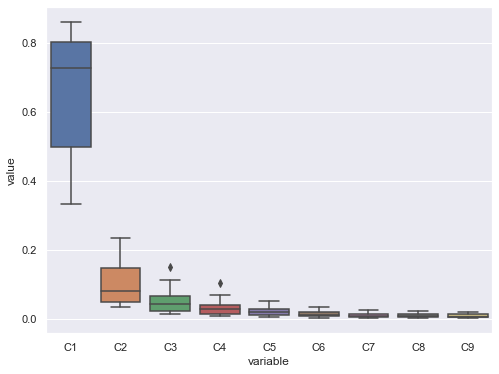

In [43]:
sns.boxplot(x="variable", y="value", data=pd.melt(pca_fpfh_df))

plt.show()

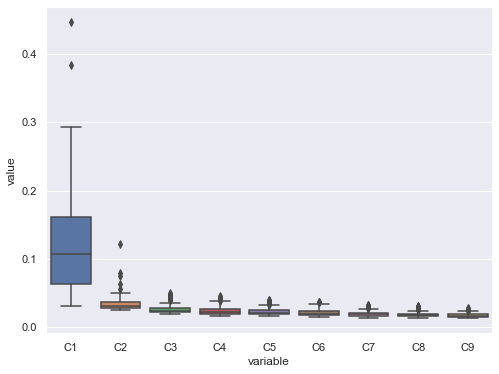

In [50]:
sns.boxplot(x="variable", y="value", data=pd.melt(pca_shot_main_df))

plt.show()

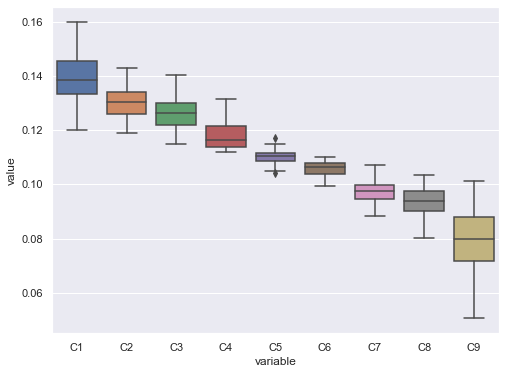

In [51]:
sns.boxplot(x="variable", y="value", data=pd.melt(pca_shot_rf_df))

plt.show()

In [150]:
#Read Downsampled point cloud
pc_o3d = o3d.io.read_point_cloud(os.path.join(OUTPUT_TEMP_PATH,f"{P_ID}_{PYMESH_FILENAME}"))

#Build tree for original point cloud
o3d_kdtree = o3d.geometry.KDTreeFlann(pc_o3d)

# Radius search 
RADIUS_SEARCH = np.around(radius_df.describe().radius_max["50%"],decimals = 5)

search_pt_min = pc_o3d.points[np.argmin(np.array(NN_dist))]
search_pt_max = pc_o3d.points[np.argmax(np.array(NN_dist))]

[k_min, idx_min, _] = o3d_kdtree.search_radius_vector_3d(search_pt_min, RADIUS_SEARCH)
[k_max, idx_max, _] = o3d_kdtree.search_radius_vector_3d(search_pt_max, RADIUS_SEARCH)

print(f"\nTotal neighbourhood points for the point with: \nmin dist = {k_min} \nmax dist = {k_max}")


Total neighbourhood points for the point with: 
min dist = 8 
max dist = 4


In [197]:
np.array(pc_o3d.points)[idx_max]

array([[ 0.02120341, -0.00085545, -0.02338964],
       [ 0.02135746, -0.00092897, -0.02336138],
       [ 0.02107149, -0.00089891, -0.02350854],
       [ 0.02124992, -0.00101906, -0.02346549]])

In [182]:
p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,"tet.ply"))
v = p.elements[0]
f = p.elements[1]

# Create the new vertex data with a new name with required dtype
a = np.empty(len(v.data), v.data.dtype.descr + [('label', 'i4')])
for name in v.data.dtype.fields:
    #re-assign
    a[name] = v[name]
a['label'] = 123
a['label'][0] = 123
a['label'][1] = 126
a['label'][2] = 129
a['label'][3] = 121

# Recreate the PlyElement instance
v = PlyElement.describe(a, 'vertex')

# Recreate the PlyData instance
p = PlyData([v, f], text=True)

p.write((os.path.join(OUTPUT_TEMP_PATH,"test.ply")))

In [176]:
v.data.dtype.fields

mappingproxy({'x': (dtype('float32'), 0),
              'y': (dtype('float32'), 4),
              'z': (dtype('float32'), 8),
              'label': (dtype('int32'), 12)})

In [194]:
p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,"tet.ply"))
v = p.elements[0]
f = p.elements[1]

# Create the new vertex data with a new name with required dtype
a = np.empty(len(v.data), v.data.dtype.descr + [('label', '|O')])
for name in v.data.dtype.fields:
    #re-assign
    a[name] = v[name]
a['label'] = [np.array([1,2,19]),np.array([1,2,1]),np.array([11,22,19]),np.array([15,12,1])]
# a['label'][0] = 123
# a['label'][1] = 126
# a['label'][2] = 129
# a['label'][3] = 121

# Recreate the PlyElement instance
v = PlyElement.describe(a, 'vertex')

# Recreate the PlyData instance
p = PlyData([v, f], text=True)

p.write((os.path.join(OUTPUT_TEMP_PATH,"test.ply")))

In [192]:
np.array([1,2,19])

array([ 1,  2, 19])

In [181]:
a

array([(0., 0., 0., 123), (0., 1., 1., 126), (1., 0., 1., 129),
       (1., 1., 0., 121)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('label', '<i4')])

In [168]:
v.data.dtype.descr + [('label', 'i4')]

[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('label', 'i4')]

In [188]:
p = PlyData.read(os.path.join(OUTPUT_TEMP_PATH,"test_fpfh.ply"))
v = p.elements[0]

In [189]:
p.elements[0].data.dtype.descr

[('fpfh', '|O')]

In [183]:
a['label']

array([123, 126, 129, 121])

In [190]:
p.elements[0].data

array([(array([84.14448  ,  0.       ,  0.       ,  0.       ,  2.3670673,
       13.488455 ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       , 84.14448  ,  0.       ,  0.       ,  2.3670673,
        8.992304 ,  0.       ,  0.       ,  2.1290843,  2.3670673,
        0.       ,  0.       , 68.52694  ,  0.       ,  0.       ,
        0.       ,  2.3670673, 13.488455 ,  8.516337 ,  7.1012025,
        0.       ,  0.       ,  0.       ], dtype=float32),),
       (array([100.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       , 100.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ,  86.40641  ,   0.       ,   0.       ,
         0.       ,   3.3983986,   6.7967973,   3.3983986,   0.       ,
         0.       ,   0.       ,   0.       ], dtype=float32),),
       (array([100.,   